# 3 Period Korean Analysis

## [1. Moduel Import]

## [2. Data Load]

## [3. Preprocess]
#### 3-1) Data Cleaning
- 특수 문자 등 제거

#### 3-2) Tagging
- kkma를 이용하여 형태소 분석

#### 3-3) Remove Stopword
- 불용어 제거

#### 3-4) Tokenize
- LDA Modeling에 사용할 수 있도록 Token화

## [4. Analysis]
#### 4-1) Frequency
- 분석 1) 전체 Text에서의 Frequency (상위 30개)
- 분석 2) 각 POS('noun', 'verb', ...)별 분포와 비율
- 분석 3) 'noun'인 token들의 Frequncy (상위 30개)
- 분석 4) 'verb'인 token들의 Frequncy (상위 30개)
- 분석 5) 'adjective'인 token들의 Frequncy (상위 30개)
- 각 분석에 대해 StopWord 제거 이전과 이후에 대한 시각화를 모두 진행하였습니다.

#### 4-2) Topic Modeling (LDA)
- 토픽의 개수(NUM_TOPICS(= k))는 각 시기 당 할당된 기사의 수가 10개 이기 때문에 10으로 설정하였습니다.
- 실험적으로 최적의 k 값을 찾아나갈 예정입니다.
- Modeling에는 noun Token들만 추출하여 LDA 분석하였습니다.

#### 4-3) WordCloud
- 각 시기 별 Token들의 WordCloud
- noun token들만을 추출하여 WordCloud를 시각화하였습니다.

#### ~~4-4) Network web analysis~~
- 연관 관계 계산과정에서 실행시간이 오래 걸려서 먼저 완성할 수 있는 시각화 분석을 먼저 수행하였습니다.

## 1. Module Import

In [65]:
# self defined moduels
from myModules.utils.data.DataLoader import DataLoader
from myModules.utils.merge.mergeOverPeriod import merge
from myModules.preprocess import cleaning, tagging, removeStopWord_TT, tokenizing_TT
from myModules.plot.plotFrequency import calcTags, CountNLabelOverPOS, showCountNRate, tag2csv,plotOverallFrequency ,plotTagFrequency, plotPOSFrequency
from myModules.plot.plotWordCloud import plotWordCloud
from myModules.TopicModeling.LDA.ldaModeling import buildDTM, topicWords, visualizeLDA


# General Module
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

# Read File
import glob

# NLP
## tweepy version prob => install tweepy with version 3.9.0 
from gensim import models
from apyori import apriori


# Visualization
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Data Load

In [2]:
DATA_ROOT = './Data/3구간/'

PERIOD_1 = DATA_ROOT + '1시기/1시기_TT/'
PERIOD_2 = DATA_ROOT + '2시기/2시기_TT/'
PERIOD_3 = DATA_ROOT + '3시기/3시기_TT/'

RESULT_ROOT = './Result/3구간/'

RESULT_1 = RESULT_ROOT + '/1시기/TT/'
RESULT_2 = RESULT_ROOT + '/2시기/TT/'
RESULT_3 = RESULT_ROOT + '/3시기/TT/'

In [3]:
files_1 = glob.glob(PERIOD_1+'*.txt')
files_2 = glob.glob(PERIOD_2+'*.txt')
files_3 = glob.glob(PERIOD_3+'*.txt')

texts_1 = DataLoader(files_1, mode='TT')
texts_2 = DataLoader(files_2, mode='TT')
texts_3 = DataLoader(files_3, mode='TT')

## 3. Preprocess

### 3-1. Data Cleaning

In [6]:
cleaned_1 = cleaning(texts_1, mode='TT')
cleaned_2 = cleaning(texts_2, mode='TT')
cleaned_3 = cleaning(texts_3, mode='TT')

### 3-2. Taggging

In [7]:
tagged_1 = tagging(cleaned_1, mode='TT')
tagged_2 = tagging(cleaned_2, mode='TT')
tagged_3 = tagging(cleaned_3, mode='TT')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

### 3-3. Remove Stopword

#### Tag List 정의

In [8]:
tagList = [['noun', ['NN','NNS','NNP','NNPS'], ['NNG','NNB','NNP','NNM']], \
    ['pronoun', ['PRP','WP','PRP'], ['NP']],
    ['verb', ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'], ['VV', 'VXV', 'VCP']],
    ['adjective', ['JJ', 'JJR', 'JJS'], ['VA', 'VXA', 'VCN']],
    ['adverb', ['RB', 'RBR', 'RBS', 'WRB', 'EX', 'RP'], ['MAG']],
    ['prep&conj', ['TO', 'IN', 'CC'], ['MAC']],
    ['determiner', ['DT', 'PDT', 'WDT'], ['MDT', 'MDN']],
    ['interjection',['UH'], ['IC']],
    ['number', ['CD'], ['NR', 'ON']],
    ['foreignW', ['FW'],['OL']],
    ['modal',['MD'],[]],
    ['josa', [], ['JC', 'JK', 'JKC', 'JKG', 'JKI', 'JKM', 'JKO', 'JKQ', 'JKS', 'JX']],
    ['possesiveS', ['POS'], []],
    ['others',['LS'], ['EPH', 'EPT', 'EPP', 'EFN', 'EFQ', 'EFO', 'EFA', 'EFI', 'EFR', 'ECE', 'ECD', 'ECS', 'ETN', 'ETD', 'XPN', 'XPV', 'XSN', 'XSV', 'XSA', 'XR', 'UN', 'OH']]]

tagList = pd.DataFrame(tagList)
tagList.columns = ['POS', 'Eng_tag', 'Kor_tag']

#### Stopword 정의

Stopword는 다음과 같이 설정하였습니다.
- 감탄사 : 'IC'
- 조사 : 'JC', 'JK', 'JKC', 'JKG', 'JKI', 'JKM', 'JKO', 'JKQ', 'JKS', 'JX'
- 어미 : 'EPH', 'EPT', 'EPP', 'EFN', 'EFQ', 'EFO', 'EFA', 'EFI', 'EFR', 'ECE', 'ECD', 'ECS', 'ETN', 'ETD'
- 접두사 : 'XPN', 'XPV'
- 접미사 : 'XSN', 'XSV', 'XSA'
- 어근 : 'XR'
- 명사추정범주 : 'UN'
- 한자 : 'OH'
- 외국어 : 'OL'
- 숫자 : 'ON'
- [https://www.ranks.nl/stopwords/korean](https://www.ranks.nl/stopwords/korean) 에 나타나 있는 보편적인 한국어 불용어

In [9]:
stop_tag_list = ['IC', 'JC', 'JK', 'JKC', 'JKG', 'JKI', 'JKM', 'JKO', 'JKQ', 'JKS', 'JX', 'EPH', \
    'EPT', 'EPP', 'EFN', 'EFQ', 'EFO', 'EFA', 'EFI', 'EFR', 'ECE', 'ECD', 'ECS', 'ETN', 'ETD',
    'XSN', 'XSV', 'XSA', 'UN', 'OH', 'OL', 'ON', 'XPN', 'XPV', 'XR']

Kor_stopwords = ''

with open("./Data/Kor_stopwords.txt", 'r', encoding='utf-8') as f:
    stopword = f.read()
    Kor_stopwords = stopword

Kor_stopwords = Kor_stopwords.split('\n')

#### Stopword 제거

In [10]:
wo_stopword_1 = removeStopWord_TT(tagged_1, stop_tag_list, Kor_stopwords)
wo_stopword_2 = removeStopWord_TT(tagged_2, stop_tag_list, Kor_stopwords)
wo_stopword_3 = removeStopWord_TT(tagged_3, stop_tag_list, Kor_stopwords)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

### 3-4. Tokenize

In [11]:
tokenized_1 = tokenizing_TT(wo_stopword_1, tagList, 'all')
tokenized_2 = tokenizing_TT(wo_stopword_2, tagList, 'all')
tokenized_3 = tokenizing_TT(wo_stopword_3, tagList, 'all')

## 4. Analysis

### 4-1. Frequency

#### Period 1

In [12]:
countDict_1, classDict_1 = calcTags(merge(tagged_1), tagList, mode='TT')
wo_countDict_1, wo_classDict_1 = calcTags(merge(wo_stopword_1), tagList, mode='TT')

  0%|          | 0/94094 [00:00<?, ?it/s]

  0%|          | 0/28940 [00:00<?, ?it/s]

##### 분석 1) 전체 Text에서의 Frequency (상위 30개)

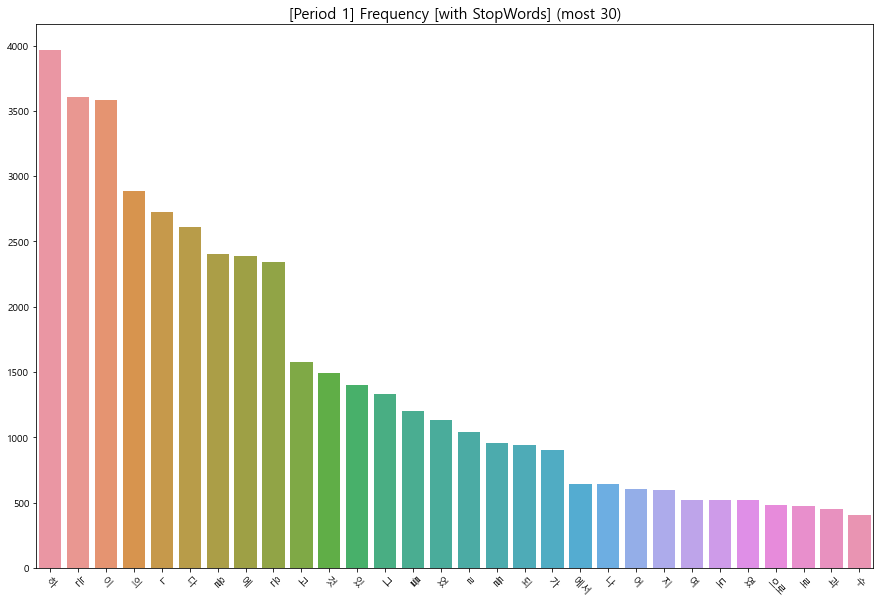

In [14]:
plotOverallFrequency(merge(tokenizing_TT(tagged_1, tagList, pos='all')), filepath=RESULT_1+'Frequency/', wo=False, period=1, mode='TT')

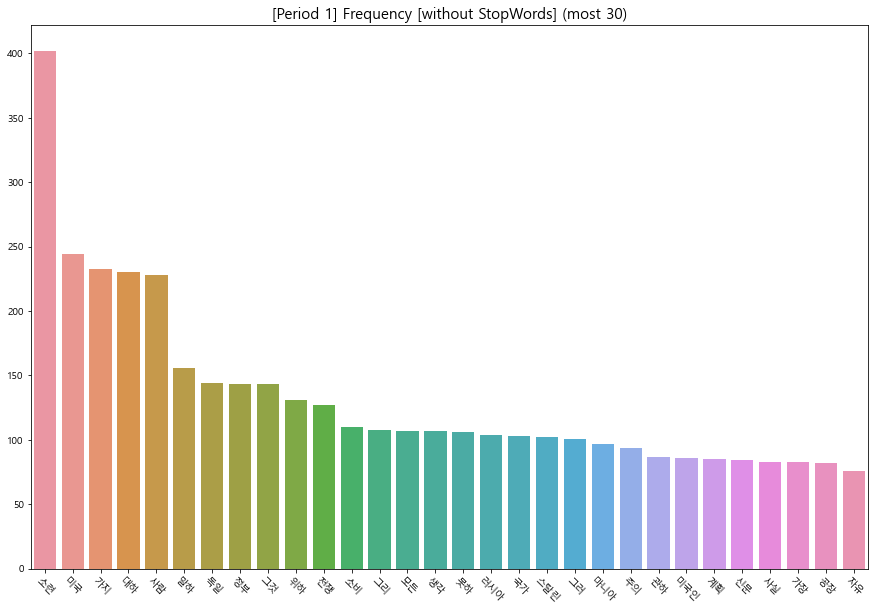

In [15]:
plotOverallFrequency(merge(tokenized_1), filepath=RESULT_1+'Frequency/', wo=True, period=1, mode='TT')

##### 분석 2) 각 POS('noun', 'verb', ...)별 분포와 비율

In [16]:
showCountNRate(countDict_1, "with Stopwords")

[with Stopwords]
-------------------------
전체 토큰 수 | 94094개
[noun] 토큰 수 : 30894개 | 비율 : 32.83%
[pronoun] 토큰 수 : 2286개 | 비율 : 2.43%
[verb] 토큰 수 : 10419개 | 비율 : 11.07%
[adjective] 토큰 수 : 1596개 | 비율 : 1.7%
[adverb] 토큰 수 : 3110개 | 비율 : 3.31%
[prepnconj] 토큰 수 : 237개 | 비율 : 0.25%
[determiner] 토큰 수 : 1522개 | 비율 : 1.62%
[interjection] 토큰 수 : 5개 | 비율 : 0.01%
[number] 토큰 수 : 232개 | 비율 : 0.25%
[foreignW] 토큰 수 : 87개 | 비율 : 0.09%
[modal] 토큰 수 : 0개 | 비율 : 0.0%
[josa] 토큰 수 : 18744개 | 비율 : 19.92%
[possesiveS] 토큰 수 : 0개 | 비율 : 0.0%
[others] 토큰 수 : 24812개 | 비율 : 26.37%
-------------------------


In [17]:
showCountNRate(wo_countDict_1, "without Stopwords")

[without Stopwords]
-------------------------
전체 토큰 수 | 28940개
[noun] 토큰 수 : 23104개 | 비율 : 79.83%
[pronoun] 토큰 수 : 207개 | 비율 : 0.72%
[verb] 토큰 수 : 3258개 | 비율 : 11.26%
[adjective] 토큰 수 : 571개 | 비율 : 1.97%
[adverb] 토큰 수 : 1462개 | 비율 : 5.05%
[prepnconj] 토큰 수 : 0개 | 비율 : 0.0%
[determiner] 토큰 수 : 151개 | 비율 : 0.52%
[interjection] 토큰 수 : 0개 | 비율 : 0.0%
[number] 토큰 수 : 84개 | 비율 : 0.29%
[foreignW] 토큰 수 : 0개 | 비율 : 0.0%
[modal] 토큰 수 : 0개 | 비율 : 0.0%
[josa] 토큰 수 : 0개 | 비율 : 0.0%
[possesiveS] 토큰 수 : 0개 | 비율 : 0.0%
[others] 토큰 수 : 0개 | 비율 : 0.0%
-------------------------


In [18]:
tag2csv(countDict_1, classDict_1, tagList, RESULT_1 +'Frequency-in-POS/' + "Frequency over POS-withstopword", mode='TT')
tag2csv(wo_countDict_1, wo_classDict_1, tagList, RESULT_1  +'Frequency-in-POS/' + "Frequency over POS-withoutstopword", mode='TT')

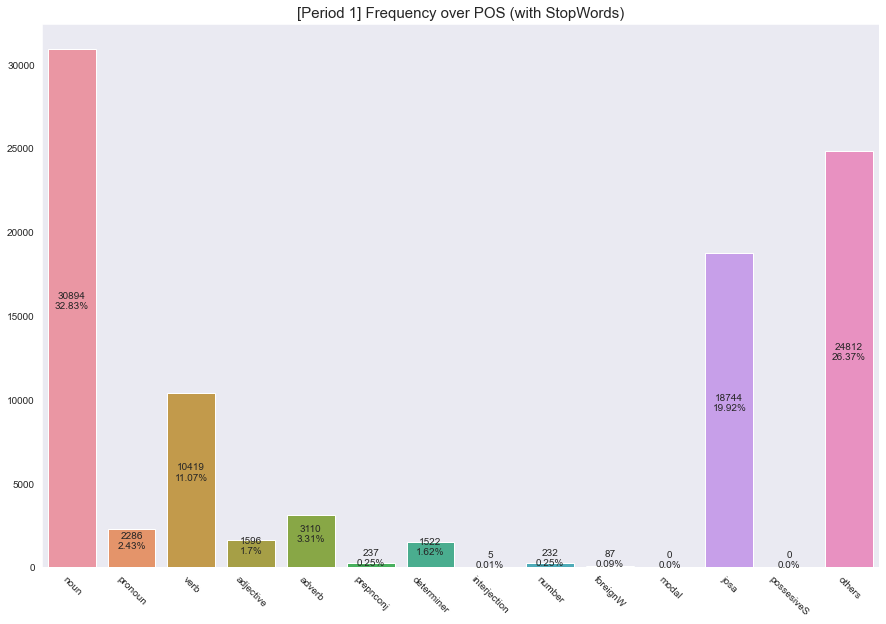

In [19]:
count, labels = CountNLabelOverPOS(countDict_1)

plotTagFrequency(count, labels, "[Period 1] Frequency over POS (with StopWords)", RESULT_1 +'Frequency-in-POS/')

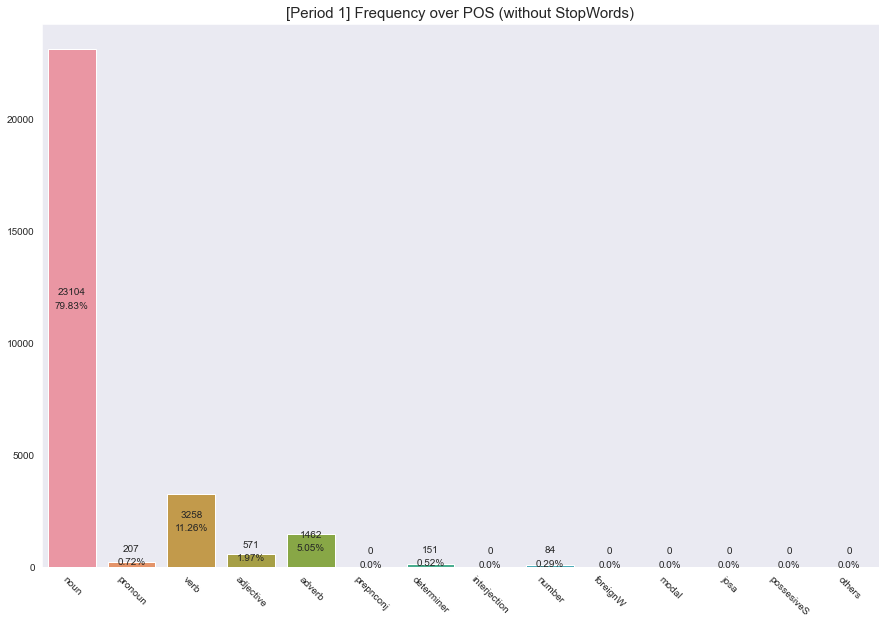

In [20]:
count, labels = CountNLabelOverPOS(wo_countDict_1)

plotTagFrequency(count, labels, "[Period 1] Frequency over POS (without StopWords)", RESULT_1 +'Frequency-in-POS/')

##### 분석 3) 'noun'인 token들의 Frequncy (상위 30개)

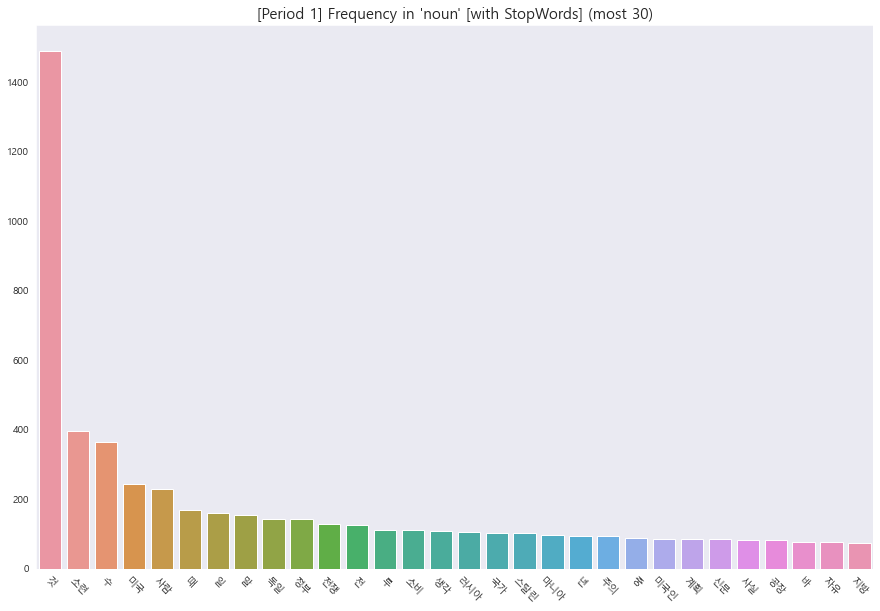

In [22]:
plotPOSFrequency(classDict_1, filepath=RESULT_1 +'Frequency-in-noun/', pos='noun', wo=False, period=1, mode='TT')

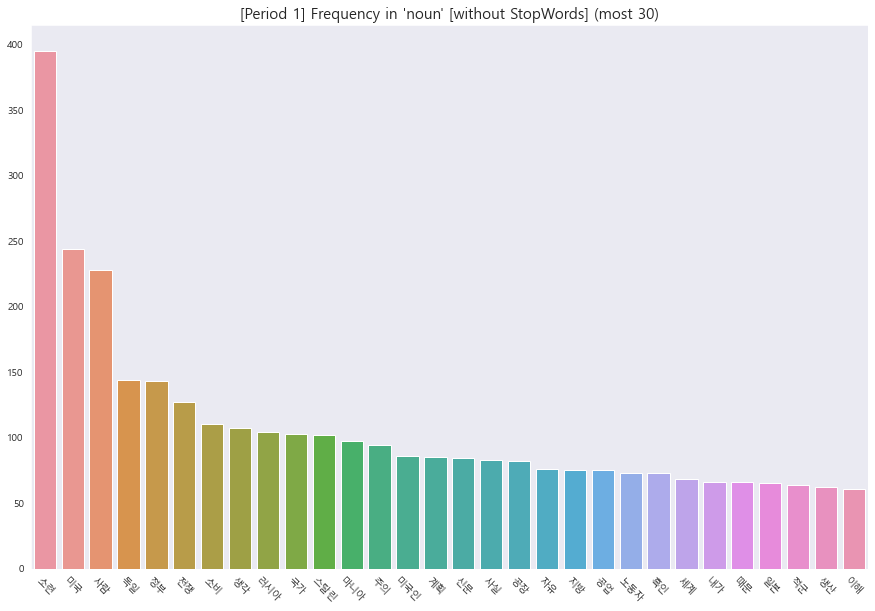

In [23]:
plotPOSFrequency(wo_classDict_1, filepath=RESULT_1 +'Frequency-in-noun/', pos='noun', wo=True, period=1, mode='TT')

##### 분석 4) 'verb'인 token들의 Frequncy (상위 30개)

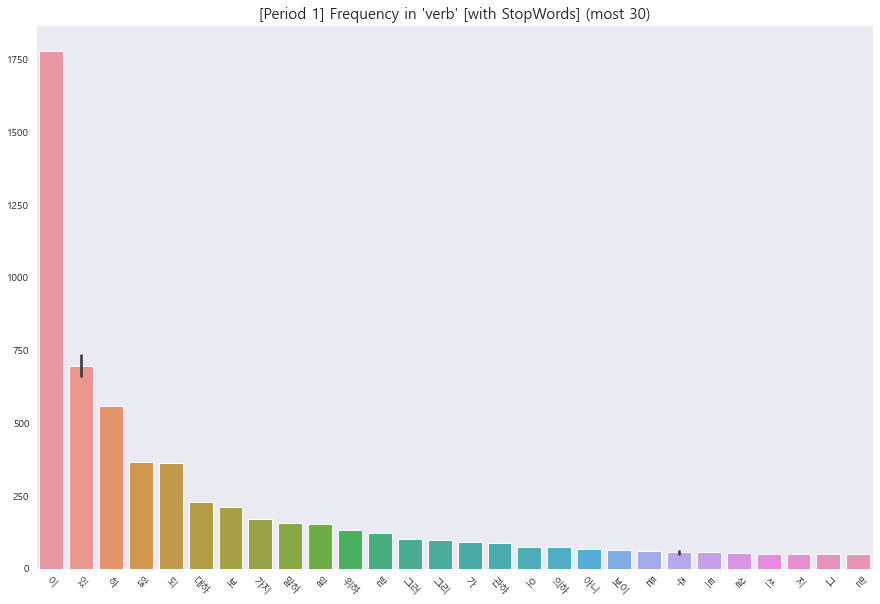

In [24]:
plotPOSFrequency(classDict_1, filepath=RESULT_1 +'Frequency-in-verb/', pos='verb', wo=False, period=1, mode='TT')

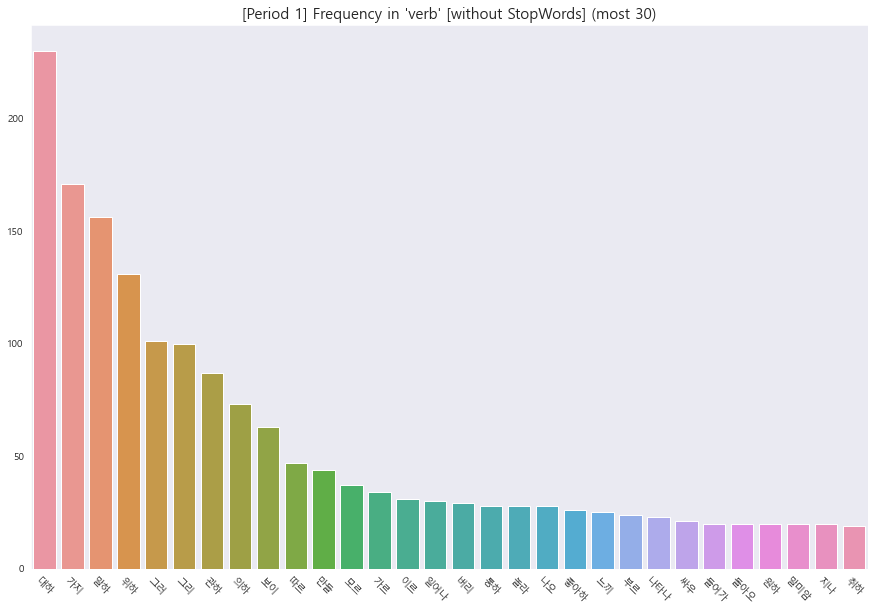

In [25]:
plotPOSFrequency(wo_classDict_1, filepath=RESULT_1+'Frequency-in-verb/', pos='verb', wo=True, period=1, mode='TT')

##### 분석 5) 'adjective'인 token들의 Frequncy (상위 30개)

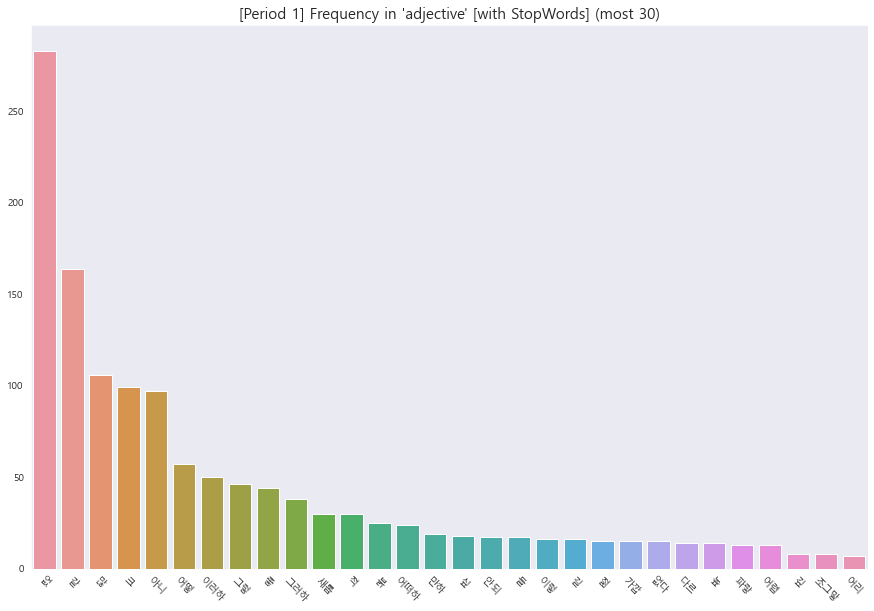

In [26]:
plotPOSFrequency(classDict_1, filepath=RESULT_1+'Frequency-in-adjective/', pos='adjective', wo=False, period=1, mode='TT')

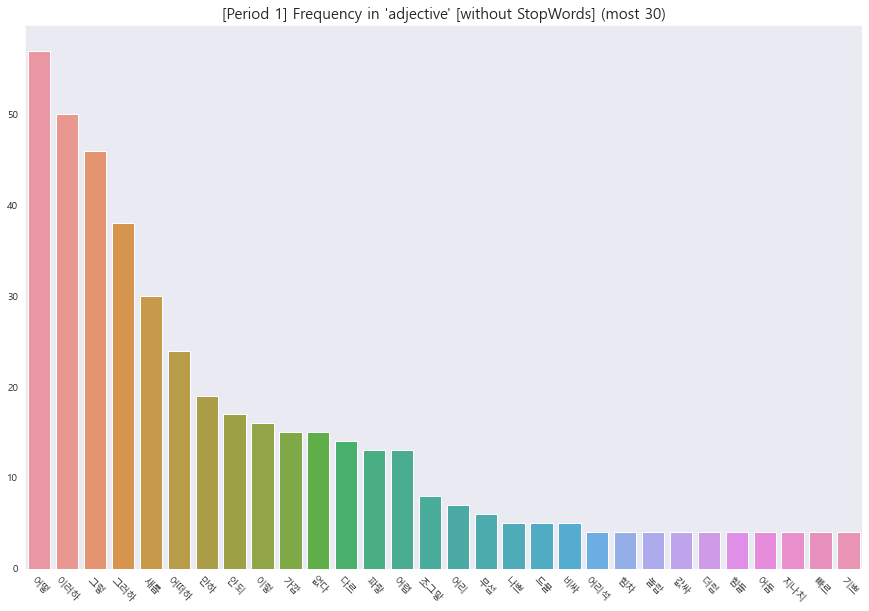

In [27]:
plotPOSFrequency(wo_classDict_1, filepath=RESULT_1+'Frequency-in-adjective/', pos='adjective', wo=True, period=1, mode='TT')

#### Period 2

In [28]:
countDict_2, classDict_2 = calcTags(merge(tagged_2), tagList, mode='TT')
wo_countDict_2, wo_classDict_2 = calcTags(merge(wo_stopword_2), tagList, mode='TT')

  0%|          | 0/38067 [00:00<?, ?it/s]

  0%|          | 0/12503 [00:00<?, ?it/s]

##### 분석 1) 전체 Text에서의 Frequency (상위 30개)

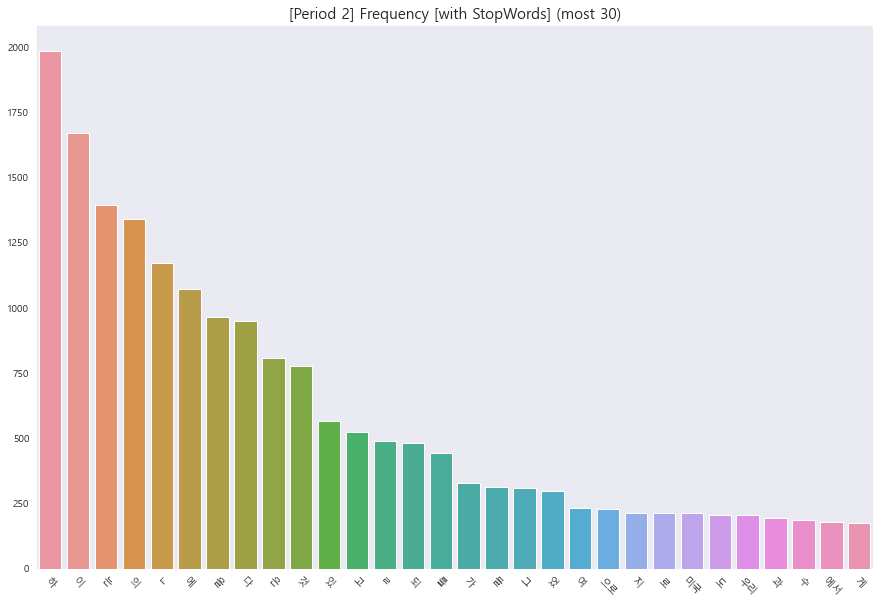

In [29]:
plotOverallFrequency(merge(tokenizing_TT(tagged_2, tagList, pos='all')), filepath=RESULT_2+'Frequency/', wo=False, period=2, mode='TT')

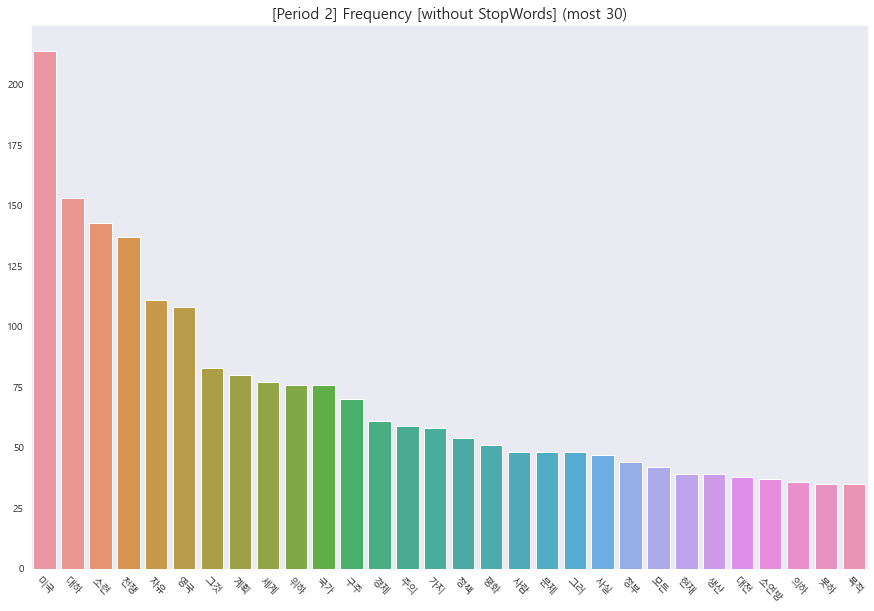

In [30]:
plotOverallFrequency(merge(tokenized_2), filepath=RESULT_2+'Frequency/', wo=True, period=2, mode='TT')

##### 분석 2) 각 POS('noun', 'verb', ...)별 분포와 비율

In [31]:
showCountNRate(countDict_2, "with Stopwords")

[with Stopwords]
-------------------------
전체 토큰 수 | 38067개
[noun] 토큰 수 : 13543개 | 비율 : 35.58%
[pronoun] 토큰 수 : 634개 | 비율 : 1.67%
[verb] 토큰 수 : 3775개 | 비율 : 9.92%
[adjective] 토큰 수 : 512개 | 비율 : 1.34%
[adverb] 토큰 수 : 1070개 | 비율 : 2.81%
[prepnconj] 토큰 수 : 121개 | 비율 : 0.32%
[determiner] 토큰 수 : 520개 | 비율 : 1.37%
[interjection] 토큰 수 : 4개 | 비율 : 0.01%
[number] 토큰 수 : 157개 | 비율 : 0.41%
[foreignW] 토큰 수 : 152개 | 비율 : 0.4%
[modal] 토큰 수 : 0개 | 비율 : 0.0%
[josa] 토큰 수 : 7579개 | 비율 : 19.91%
[possesiveS] 토큰 수 : 0개 | 비율 : 0.0%
[others] 토큰 수 : 9942개 | 비율 : 26.12%
-------------------------


In [32]:
showCountNRate(wo_countDict_2, "without Stopwords")

[without Stopwords]
-------------------------
전체 토큰 수 | 12503개
[noun] 토큰 수 : 10507개 | 비율 : 84.04%
[pronoun] 토큰 수 : 99개 | 비율 : 0.79%
[verb] 토큰 수 : 1018개 | 비율 : 8.14%
[adjective] 토큰 수 : 188개 | 비율 : 1.5%
[adverb] 토큰 수 : 534개 | 비율 : 4.27%
[prepnconj] 토큰 수 : 0개 | 비율 : 0.0%
[determiner] 토큰 수 : 73개 | 비율 : 0.58%
[interjection] 토큰 수 : 0개 | 비율 : 0.0%
[number] 토큰 수 : 49개 | 비율 : 0.39%
[foreignW] 토큰 수 : 0개 | 비율 : 0.0%
[modal] 토큰 수 : 0개 | 비율 : 0.0%
[josa] 토큰 수 : 0개 | 비율 : 0.0%
[possesiveS] 토큰 수 : 0개 | 비율 : 0.0%
[others] 토큰 수 : 0개 | 비율 : 0.0%
-------------------------


In [33]:
tag2csv(countDict_2, classDict_2, tagList, RESULT_2 +'Frequency-in-POS/' + "Frequency over POS-withstopword", mode='TT')
tag2csv(wo_countDict_2, wo_classDict_2, tagList, RESULT_2+'Frequency-in-POS/' + "Frequency over POS-withoutstopword", mode='TT')

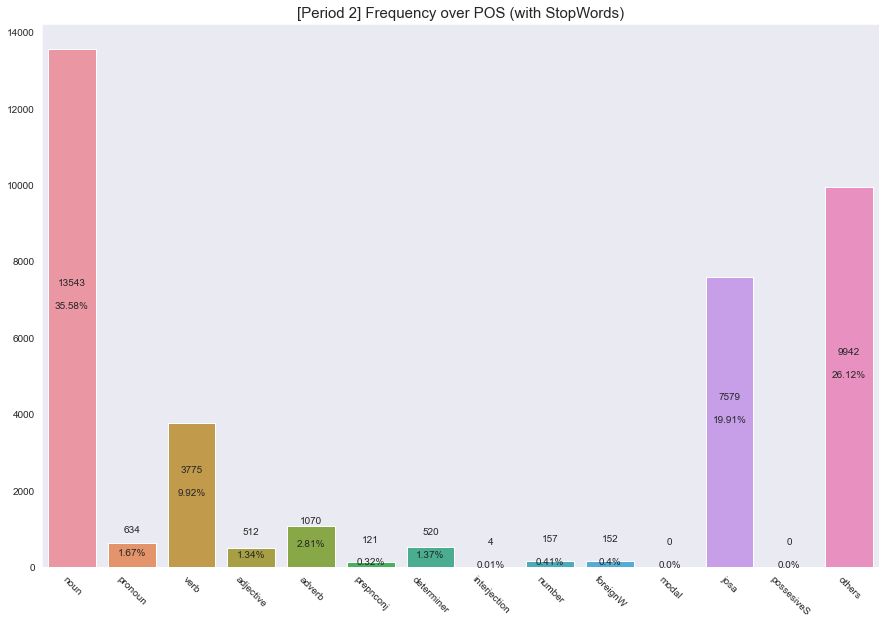

In [34]:
count, labels = CountNLabelOverPOS(countDict_2)

plotTagFrequency(count, labels, "[Period 2] Frequency over POS (with StopWords)", RESULT_2+'Frequency-in-POS/')

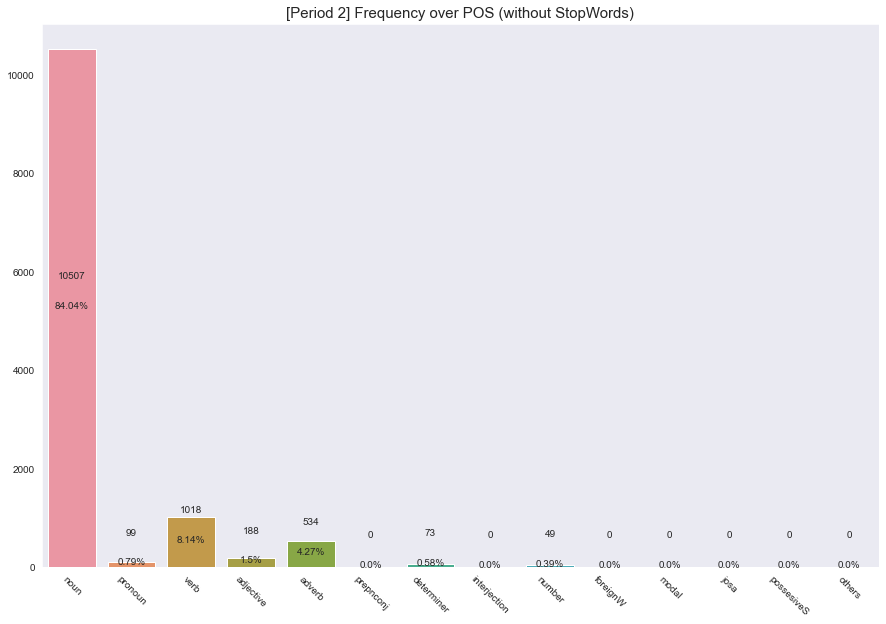

In [35]:
count, labels = CountNLabelOverPOS(wo_countDict_2)

plotTagFrequency(count, labels, "[Period 2] Frequency over POS (without StopWords)", RESULT_2+'Frequency-in-POS/')

##### 분석 3) 'noun'인 token들의 Frequncy (상위 30개)

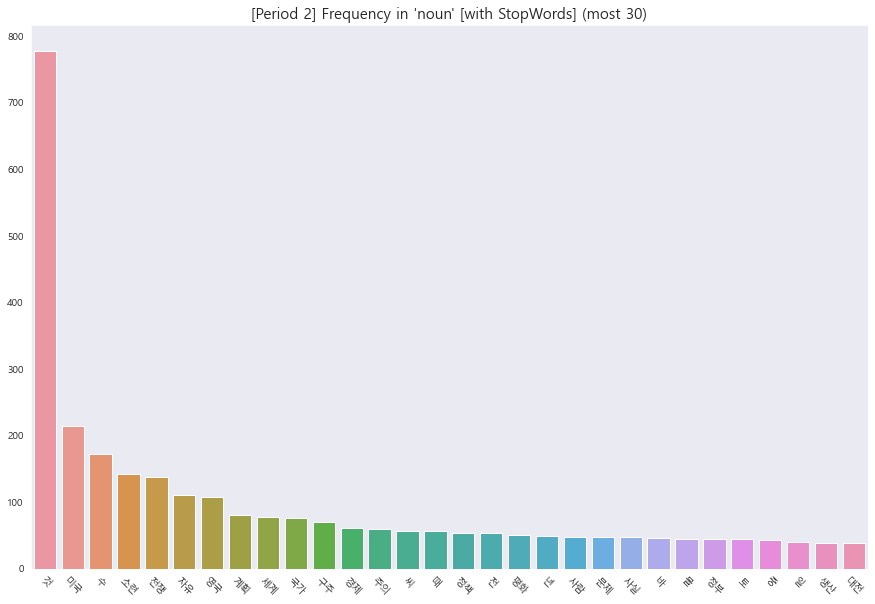

In [37]:
plotPOSFrequency(classDict_2, filepath=RESULT_2+'Frequency-in-noun/', pos='noun', wo=False, period=2, mode='TT')

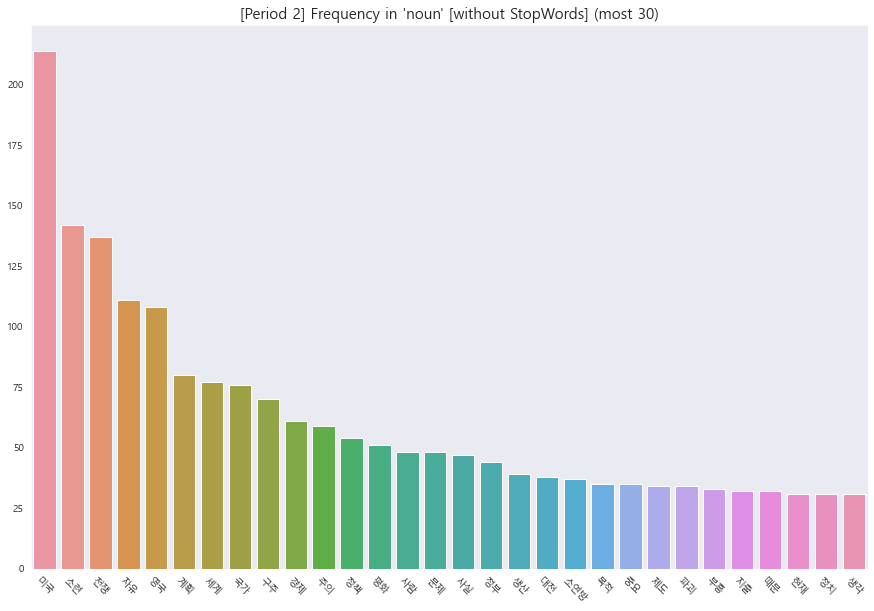

In [38]:
plotPOSFrequency(wo_classDict_2, filepath=RESULT_2+'Frequency-in-noun/', pos='noun', wo=True, period=2, mode='TT')

##### 분석 4) 'verb'인 token들의 Frequncy (상위 30개)

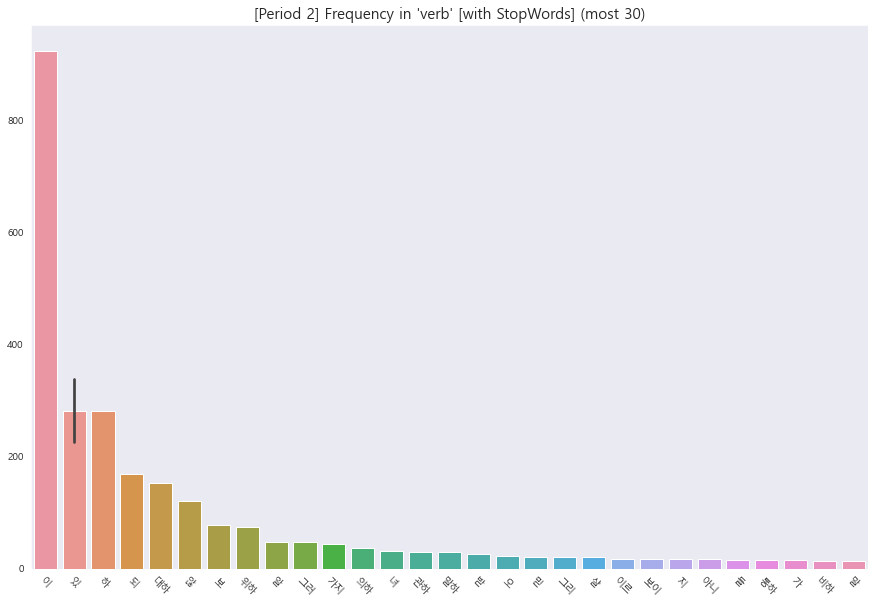

In [39]:
plotPOSFrequency(classDict_2, filepath=RESULT_2+'Frequency-in-verb/', pos='verb', wo=False, period=2, mode='TT')

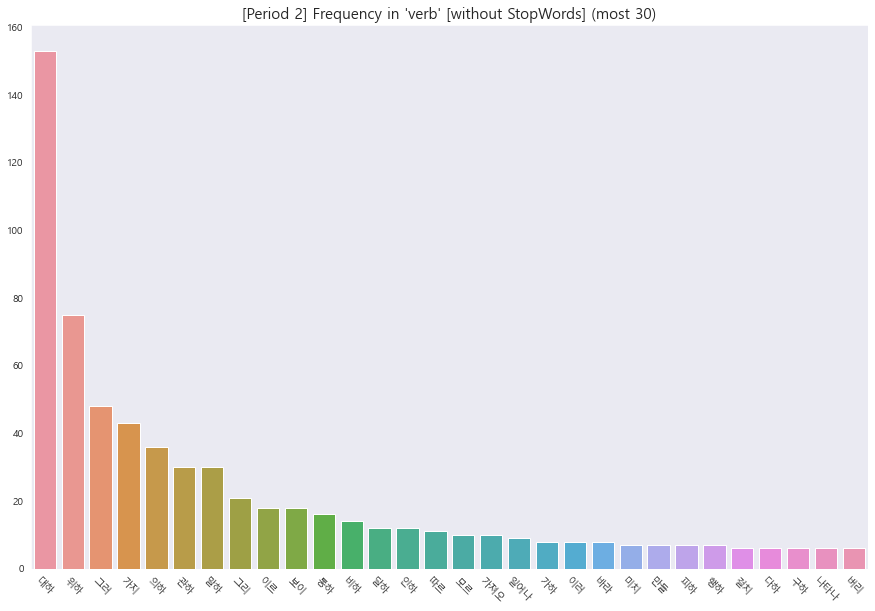

In [40]:
plotPOSFrequency(wo_classDict_2, filepath=RESULT_2+'Frequency-in-verb/', pos='verb', wo=True, period=2, mode='TT')

##### 분석 5) 'adjective'인 token들의 Frequncy (상위 30개)

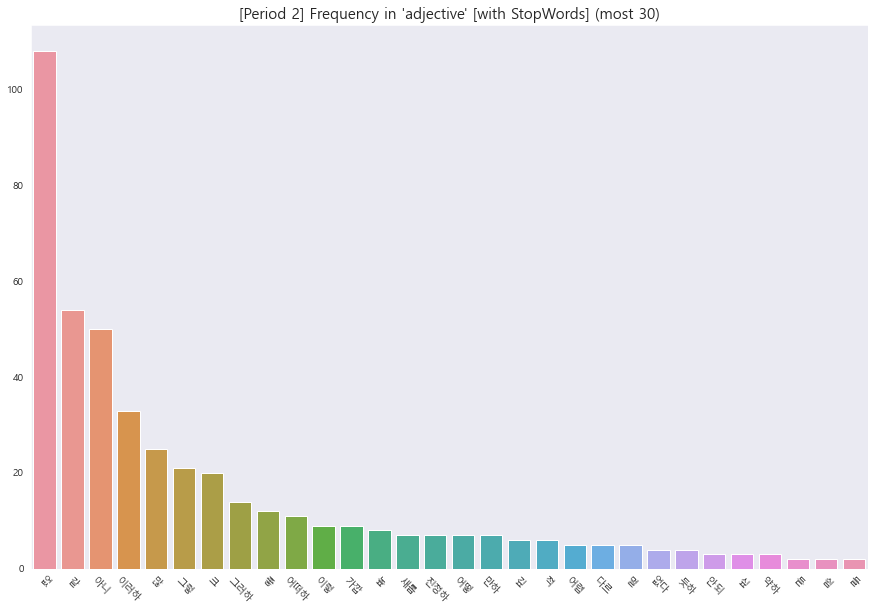

In [41]:
plotPOSFrequency(classDict_2, filepath=RESULT_2+'Frequency-in-adjective/', pos='adjective', wo=False, period=2, mode='TT')

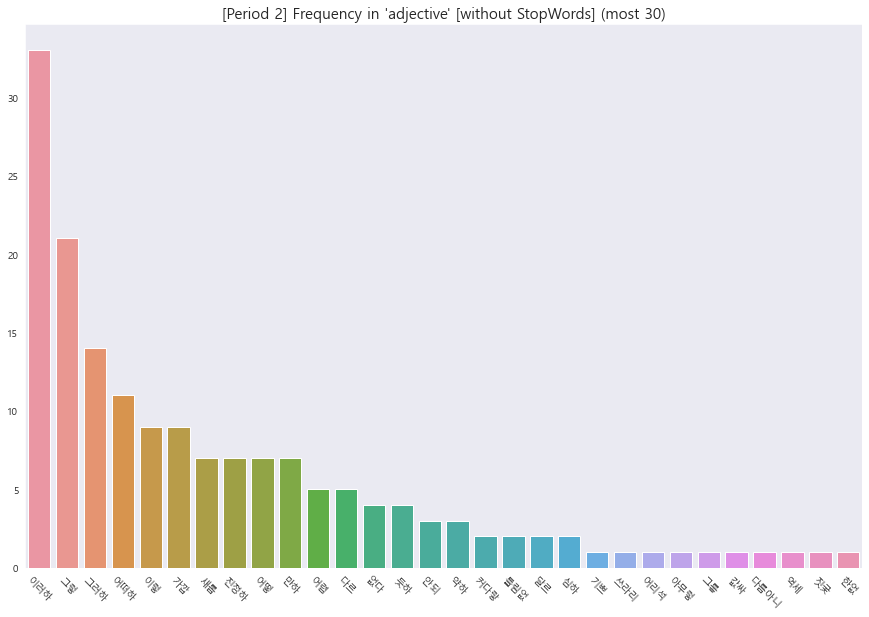

In [42]:
plotPOSFrequency(wo_classDict_2, filepath=RESULT_2+'Frequency-in-adjective/', pos='adjective', wo=True, period=2, mode='TT')

#### Period 3

In [43]:
countDict_3, classDict_3 = calcTags(merge(tagged_3), tagList, mode='TT')
wo_countDict_3, wo_classDict_3 = calcTags(merge(wo_stopword_3), tagList, mode='TT')

  0%|          | 0/58736 [00:00<?, ?it/s]

  0%|          | 0/19034 [00:00<?, ?it/s]

##### 분석 1) 전체 Text에서의 Frequency (상위 30개)

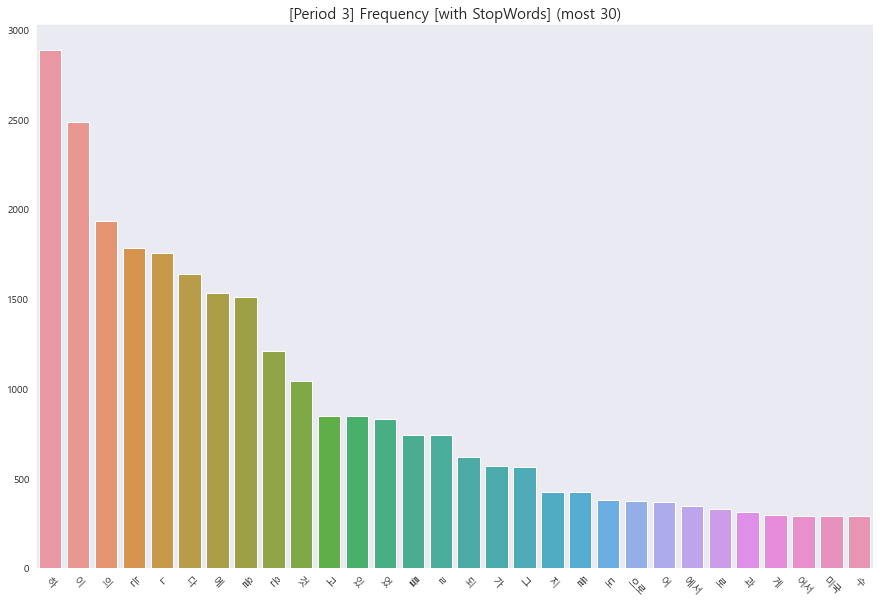

In [44]:
plotOverallFrequency(merge(tokenizing_TT(tagged_3, tagList, pos='all')), filepath=RESULT_3+'Frequency/', wo=False, period=3, mode='TT')

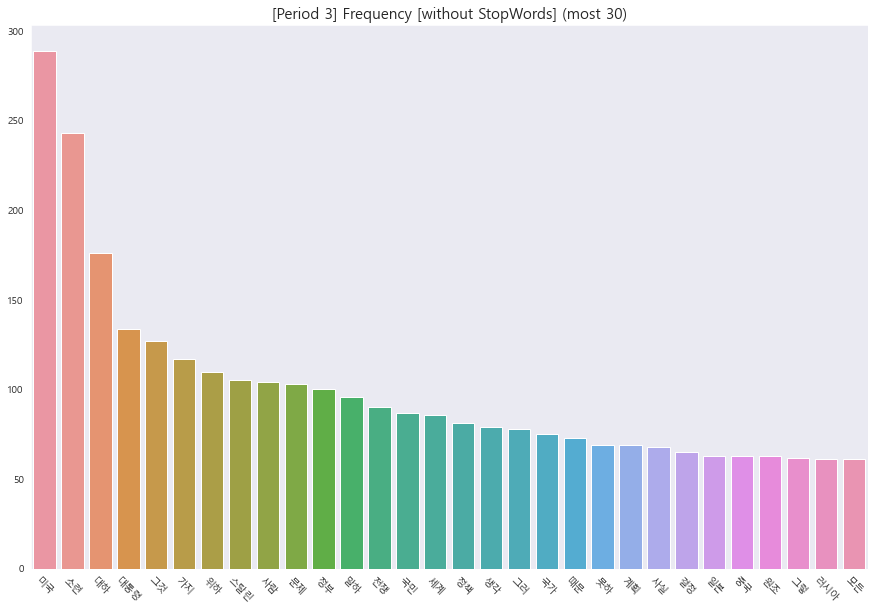

In [45]:
plotOverallFrequency(merge(tokenized_3), filepath=RESULT_3+'Frequency/', wo=True, period=3, mode='TT')

##### 분석 2) 각 POS('noun', 'verb', ...)별 분포와 비율

In [46]:
showCountNRate(countDict_3, "with Stopwords")

[with Stopwords]
-------------------------
전체 토큰 수 | 58736개
[noun] 토큰 수 : 20275개 | 비율 : 34.52%
[pronoun] 토큰 수 : 1010개 | 비율 : 1.72%
[verb] 토큰 수 : 6339개 | 비율 : 10.79%
[adjective] 토큰 수 : 943개 | 비율 : 1.61%
[adverb] 토큰 수 : 1531개 | 비율 : 2.61%
[prepnconj] 토큰 수 : 161개 | 비율 : 0.27%
[determiner] 토큰 수 : 849개 | 비율 : 1.45%
[interjection] 토큰 수 : 6개 | 비율 : 0.01%
[number] 토큰 수 : 138개 | 비율 : 0.23%
[foreignW] 토큰 수 : 43개 | 비율 : 0.07%
[modal] 토큰 수 : 0개 | 비율 : 0.0%
[josa] 토큰 수 : 11720개 | 비율 : 19.95%
[possesiveS] 토큰 수 : 0개 | 비율 : 0.0%
[others] 토큰 수 : 15619개 | 비율 : 26.59%
-------------------------


In [47]:
showCountNRate(wo_countDict_3, "without Stopwords")

[without Stopwords]
-------------------------
전체 토큰 수 | 19034개
[noun] 토큰 수 : 15541개 | 비율 : 81.65%
[pronoun] 토큰 수 : 172개 | 비율 : 0.9%
[verb] 토큰 수 : 1867개 | 비율 : 9.81%
[adjective] 토큰 수 : 393개 | 비율 : 2.06%
[adverb] 토큰 수 : 868개 | 비율 : 4.56%
[prepnconj] 토큰 수 : 0개 | 비율 : 0.0%
[determiner] 토큰 수 : 95개 | 비율 : 0.5%
[interjection] 토큰 수 : 0개 | 비율 : 0.0%
[number] 토큰 수 : 31개 | 비율 : 0.16%
[foreignW] 토큰 수 : 0개 | 비율 : 0.0%
[modal] 토큰 수 : 0개 | 비율 : 0.0%
[josa] 토큰 수 : 0개 | 비율 : 0.0%
[possesiveS] 토큰 수 : 0개 | 비율 : 0.0%
[others] 토큰 수 : 0개 | 비율 : 0.0%
-------------------------


In [48]:
tag2csv(countDict_3, classDict_3, tagList, RESULT_3 +'Frequency-in-POS/' + "Frequency over POS-withstopword", mode='TT')
tag2csv(wo_countDict_3, wo_classDict_3, tagList, RESULT_3 +'Frequency-in-POS/' + "Frequency over POS-withoutstopword", mode='TT')

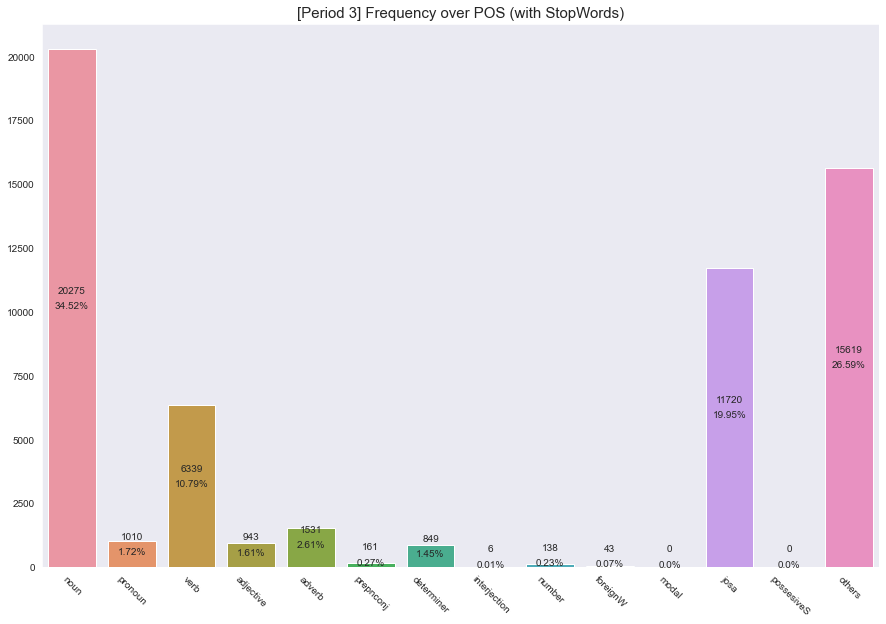

In [49]:
count, labels = CountNLabelOverPOS(countDict_3)

plotTagFrequency(count, labels, "[Period 3] Frequency over POS (with StopWords)", RESULT_3+'Frequency-in-POS/')

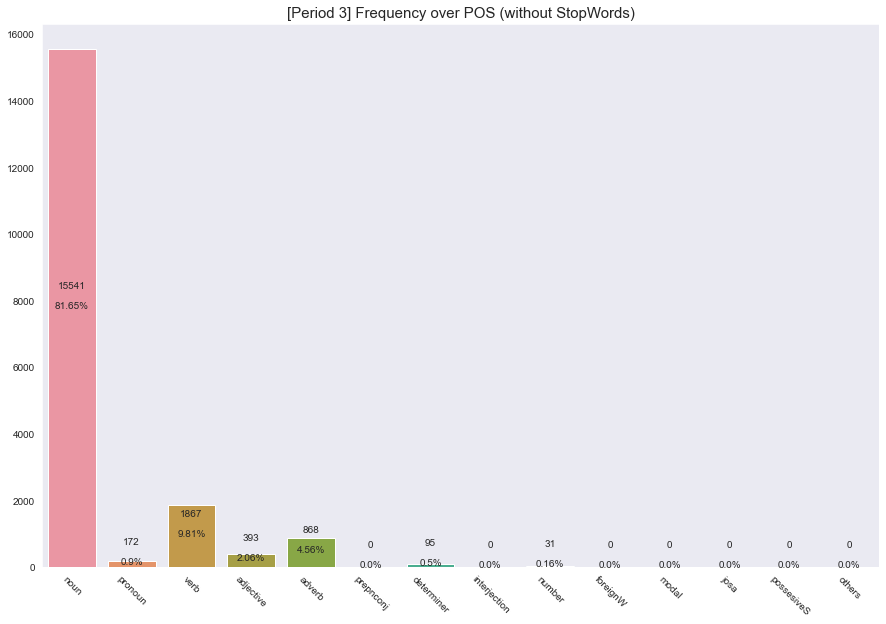

In [50]:
count, labels = CountNLabelOverPOS(wo_countDict_3)

plotTagFrequency(count, labels, "[Period 3] Frequency over POS (without StopWords)", RESULT_3+'Frequency-in-POS/')

##### 분석 3) 'noun'인 token들의 Frequncy (상위 30개)

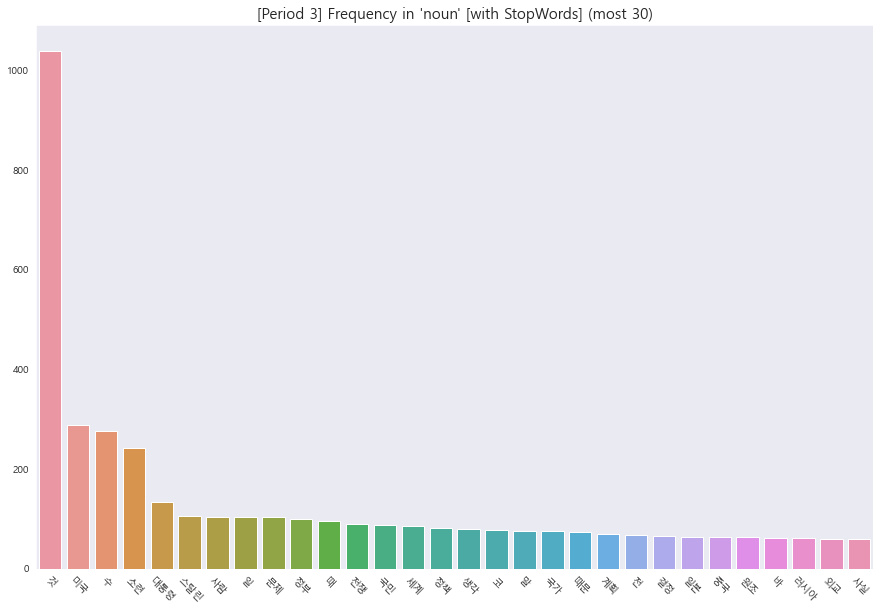

In [52]:
plotPOSFrequency(classDict_3, filepath=RESULT_3+'Frequency-in-noun/', pos='noun', wo=False, period=3, mode='TT')

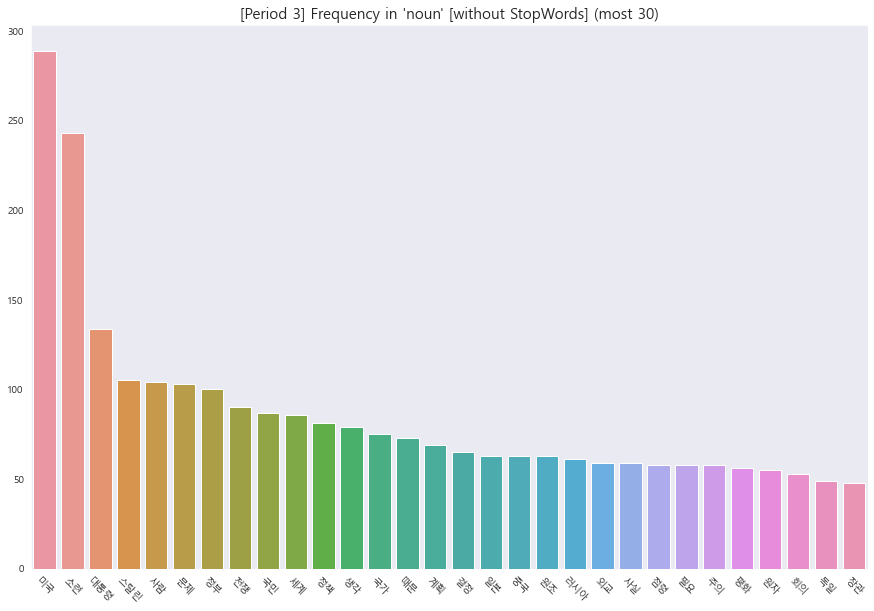

In [53]:
plotPOSFrequency(wo_classDict_3, filepath=RESULT_3+'Frequency-in-noun/', pos='noun', wo=True, period=3, mode='TT')

##### 분석 4) 'verb'인 token들의 Frequncy (상위 30개)

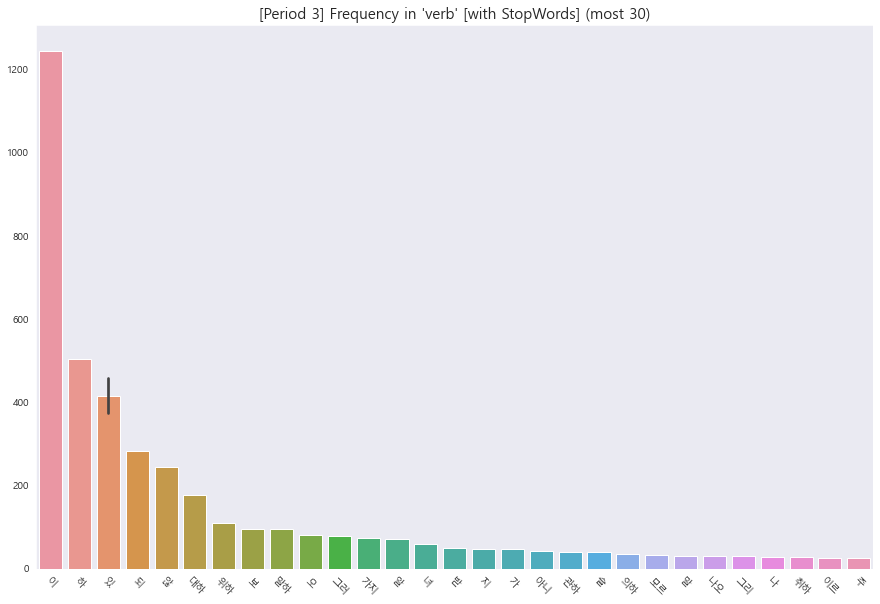

In [54]:
plotPOSFrequency(classDict_3, filepath=RESULT_3+'Frequency-in-verb/', pos='verb', wo=False, period=3, mode='TT')

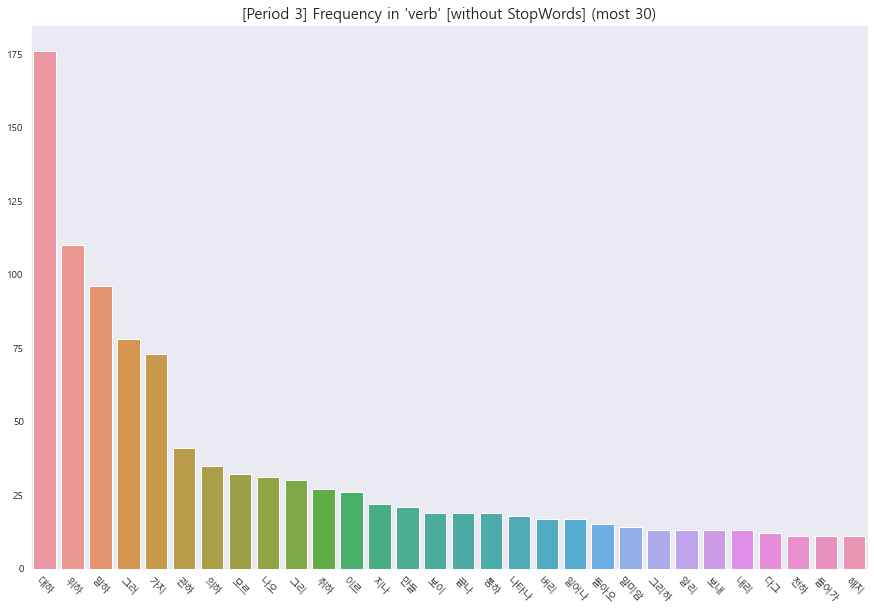

In [55]:
plotPOSFrequency(wo_classDict_3, filepath=RESULT_3+'Frequency-in-verb/', pos='verb', wo=True, period=3, mode='TT')

##### 분석 5) 'adjective'인 token들의 Frequncy (상위 30개)

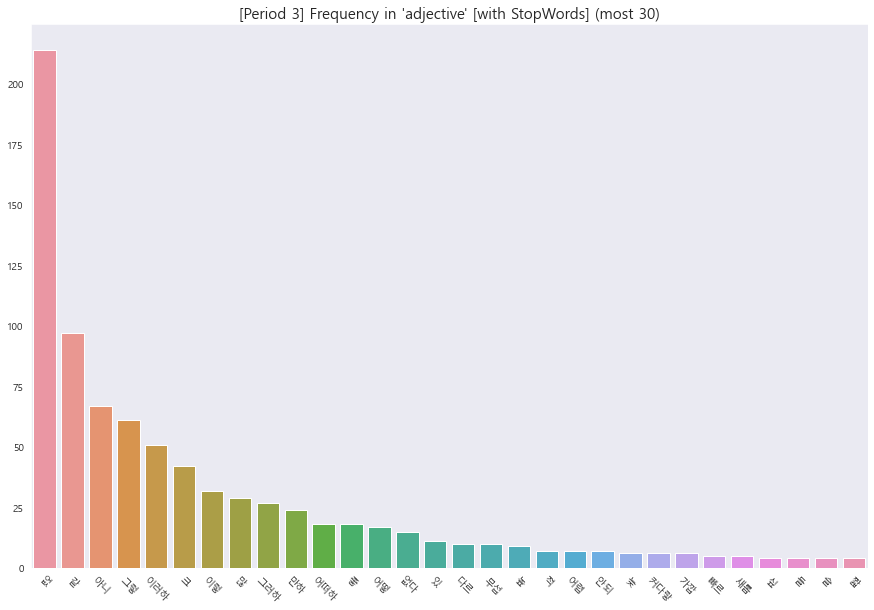

In [56]:
plotPOSFrequency(classDict_3, filepath=RESULT_3+'Frequency-in-adjective/', pos='adjective', wo=False, period=3, mode='TT')

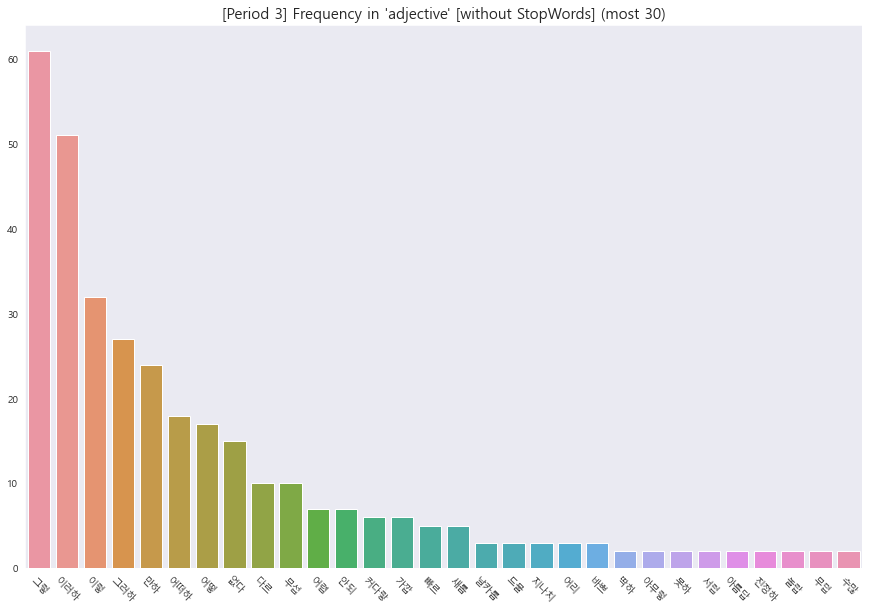

In [57]:
plotPOSFrequency(wo_classDict_3, filepath=RESULT_3+'Frequency-in-adjective/', pos='adjective', wo=True, period=3, mode='TT')

### 4-2. Topic Modeling (LDA)

#### Hyper-parameter 정의

- 각 시기 당 article의 수가 10개 였기 때문에 k=10으로 설정하고 모델링하였습니다.
- 적절한 k 값은 실험적으로 찾아보겠습니다.

In [58]:
NUM_TOPICS = 10
NUM_TOPIC_WORDS = 30

#### Period 1

In [59]:
Corp, Dict = buildDTM(tokenized_1)
model = models.ldamodel.LdaModel(Corp, num_topics = NUM_TOPICS, id2word=Dict)
topicdf = topicWords(model, NUM_TOPIC_WORDS)
data = visualizeLDA(model, Corp, Dict)

data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.014332 -0.002478       1        1  70.440169
1      0.007560 -0.007300       2        1  13.664517
6      0.000640 -0.000604       3        1   6.663088
3     -0.000698  0.002142       4        1   6.644163
8      0.004159  0.007914       5        1   1.446395
7      0.002982 -0.002629       6        1   0.895138
2     -0.004148  0.003435       7        1   0.201565
0     -0.005282 -0.000818       8        1   0.038030
9      0.007666  0.000951       9        1   0.003467
4      0.001454 -0.000614      10        1   0.003467, topic_info=    Term        Freq       Total Category  logprob  loglift
885   소련  443.000000  443.000000  Default  30.0000  30.0000
16    가지  242.000000  242.000000  Default  29.0000  29.0000
766   사람  226.000000  226.000000  Default  28.0000  28.0000
578   미국  174.000000  174.000000  Default  27.0000  27.0000
413   대하  151.000000  151.000000  Default  26.0000  26.0000
..   ...         ...         ...      ...      ...      ...
170   관하    0.002312   81.900149  Topic10  -6.0731  -0.2056
670   보이    0.002049   68.050861  Topic10  -6.1939  -0.1412
555   못하    0.002251  104.697785  Topic10  -6.0999  -0.4780
144   공장    0.002041   91.914669  Topic10  -6.1978  -0.4457
535   모든    0.001980  101.449985  Topic10  -6.2279  -0.5745

[830 rows x 6 columns], token_table=      Topic      Freq Term
term                      
2216      1  0.626345   가끔
2216      2  0.250538   가끔
2216      3  0.125269   가끔
2216      4  0.125269   가끔
14        1  0.680519   가장
...     ...       ...  ...
5518      6  0.018116   흑인
5519      1  0.513740  흑인종
5519      2  0.256870  흑인종
5519      3  0.128435  흑인종
5519      4  0.128435  흑인종

[996 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 7, 4, 9, 8, 3, 1, 10, 5])

#### Period 2

In [60]:
Corp, Dict = buildDTM(tokenized_2)
model = models.ldamodel.LdaModel(Corp, num_topics = NUM_TOPICS, id2word=Dict)
topicdf = topicWords(model, NUM_TOPIC_WORDS)

data = visualizeLDA(model, Corp, Dict)

data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.017753  0.004253       1        1  31.116447
8      0.011064  0.001385       2        1  30.066928
1     -0.010077  0.013872       3        1  18.008602
9      0.001466  0.007434       4        1  10.891507
0      0.000897 -0.016451       5        1   9.353668
2     -0.010299 -0.006671       6        1   0.514159
3      0.005534  0.003204       7        1   0.024671
5     -0.009767 -0.003220       8        1   0.008006
7      0.005698 -0.006220       9        1   0.008006
6     -0.012269  0.002414      10        1   0.008006, topic_info=    Term        Freq       Total Category  logprob  loglift
272   미국  178.000000  178.000000  Default  30.0000  30.0000
209   대하  135.000000  135.000000  Default  29.0000  29.0000
627   전쟁  117.000000  117.000000  Default  28.0000  28.0000
410   소련  102.000000  102.000000  Default  27.0000  27.0000
506   영국   74.000000   74.000000  Default  26.0000  26.0000
..   ...         ...         ...      ...      ...      ...
98    구주    0.002787   67.646664  Topic10  -5.8836  -0.6642
410   소련    0.003103  102.149397  Topic10  -5.7763  -0.9690
673   주의    0.002359   53.328344  Topic10  -6.0506  -0.5933
347   사람    0.002151   42.870098  Topic10  -6.1429  -0.4673
269   문제    0.002075   41.067274  Topic10  -6.1786  -0.4601

[799 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1651      1  0.272950   가깝
1651      2  0.272950   가깝
1651      3  0.136475   가깝
1651      4  0.136475   가깝
1651      5  0.136475   가깝
...     ...       ...  ...
855       1  0.362426   희랍
855       2  0.226516   희랍
855       3  0.181213   희랍
855       4  0.090607   희랍
855       5  0.090607   희랍

[1232 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 9, 2, 10, 1, 3, 4, 6, 8, 7])

#### Period 3

In [61]:
Corp, Dict = buildDTM(tokenized_3)
model = models.ldamodel.LdaModel(Corp, num_topics = NUM_TOPICS, id2word=Dict)
topicdf = topicWords(model, NUM_TOPIC_WORDS)

data = visualizeLDA(model, Corp, Dict)

data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.018263 -0.000575       1        1  27.108308
3     -0.003497  0.005585       2        1  13.902313
2      0.009559  0.010390       3        1  13.579846
4     -0.011045 -0.005101       4        1  11.734527
1      0.005241  0.002289       5        1   9.788261
9      0.001777 -0.008146       6        1   9.029529
5     -0.010761  0.000218       7        1   8.545133
0     -0.011132  0.006883       8        1   5.725138
6     -0.002293 -0.000109       9        1   0.581157
7      0.003886 -0.011433      10        1   0.005788, topic_info=    Term        Freq       Total Category  logprob  loglift
276   미국  218.000000  218.000000  Default  30.0000  30.0000
389   소련  219.000000  219.000000  Default  29.0000  29.0000
189   대하  139.000000  139.000000  Default  28.0000  28.0000
7     가지   93.000000   93.000000  Default  27.0000  27.0000
402  스탈린   91.000000   91.000000  Default  26.0000  26.0000
..   ...         ...         ...      ...      ...      ...
617   정책    0.002901   65.899327  Topic10  -5.9395  -0.2736
113   그러    0.002901   65.974074  Topic10  -5.9396  -0.2749
47    계획    0.002626   55.510719  Topic10  -6.0390  -0.2016
35    결정    0.002595   56.851220  Topic10  -6.0509  -0.2374
95    국민    0.002558   68.747023  Topic10  -6.0655  -0.4420

[783 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1502      1  0.230965   가격
1502      2  0.115483   가격
1502      3  0.115483   가격
1502      4  0.115483   가격
1502      5  0.115483   가격
...     ...       ...  ...
826       6  0.088637   희생
826       7  0.088637   희생
826       8  0.088637   희생
3357      1  0.327662  히로시
3357      2  0.327662  히로시

[1802 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 4, 3, 5, 2, 10, 6, 1, 7, 8])

### 4-3. WordCloud

#### Period 1

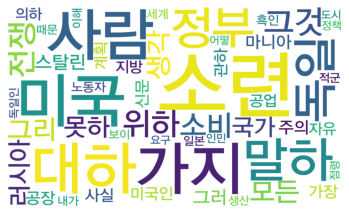

In [72]:
plotWordCloud(data=merge(tokenized_1), filepath=RESULT_1 + 'WordCloud', mode='TT')

#### Period 2

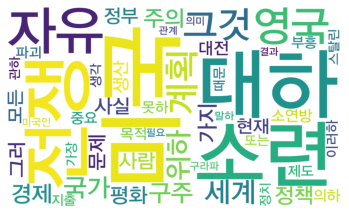

In [71]:
plotWordCloud(data=merge(tokenized_2), filepath=RESULT_2 + 'WordCloud', mode='TT')

#### Period 3

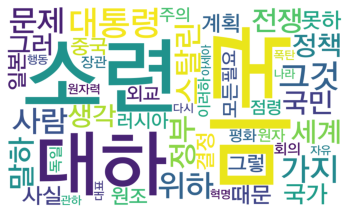

In [73]:
plotWordCloud(data=merge(tokenized_3), filepath=RESULT_3 + 'WordCloud', mode='TT')

### 4-4. Network web analysis

In [ ]:
# result = (list(apriori(tokenized_1, min_support=0.01)))

In [ ]:
# df = pd.DataFrame(result)
# df['length'] = df['items'].apply(lambda x: len(x))
# df = df[(df['length'] == 2) & \
#     (df['support'] >= 0.01)].sort_values(by='support', ascending=False)
# df.head(10)